### 주차수요 예측 AI 경진대회

🏠 유형별 임대주택 설계 시 단지 내 적정 🅿️ 주차 수요를 예측



ref: https://dacon.io/competitions/official/235745/data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
import os

os.chdir('/content/drive/MyDrive/workspace/DACON/주차수요 예측')

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [6]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
age_gender = pd.read_csv('dataset/age_gender_info.csv')

In [7]:
train.shape, test.shape, age_gender.shape

((2952, 15), (1022, 14), (16, 23))

In [8]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

## 전처리

### 결측치 확인

In [10]:
train.isna().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [11]:
train[train['임대보증금'].isna()]['자격유형'].unique()

array(['D'], dtype=object)

In [12]:
train[train['자격유형'] == 'D'].count()

단지코드                            569
총세대수                            569
임대건물구분                          569
지역                              569
공급유형                            569
전용면적                            569
전용면적별세대수                        569
공가수                             569
자격유형                            569
임대보증금                             0
임대료                               0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    435
도보 10분거리 내 버스정류장 수              569
단지내주차면수                         569
등록차량수                           569
dtype: int64

D유형은 모두 임대보증금과 임대료가 null값

In [13]:
train.fillna(0, inplace=True)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2952 non-null   object 
 10  임대료                           2952 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2952 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2952 non-null   float64
 13  단지내

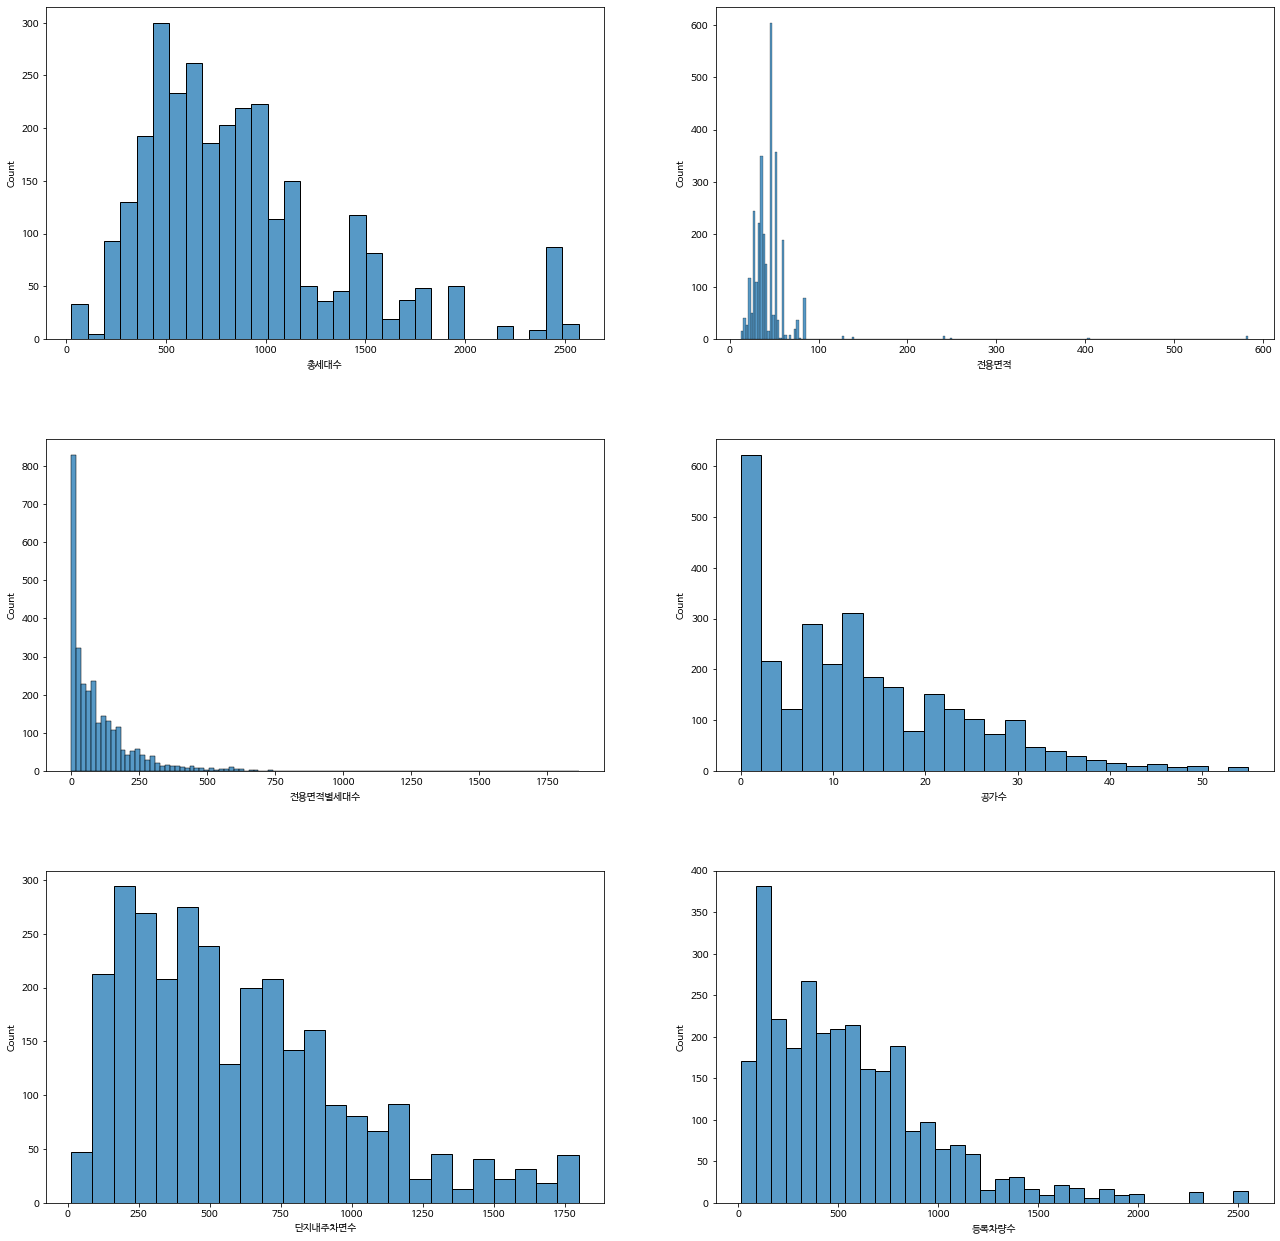

In [15]:
fig = plt.figure(figsize=(22, 22))

numeric_cols = ['총세대수', '전용면적', '전용면적별세대수', '공가수', '단지내주차면수', '등록차량수']

for i, n in enumerate(numeric_cols):
    plt.subplot(3, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.histplot(train[n])

### object 데이터 처리

In [16]:
def get_object_list():
  object_list = []
  train.columns

  for col in train.columns:
    if train[col].dtypes == 'object':
      object_list.append(col)

  return object_list

In [17]:
get_object_list()

['단지코드', '임대건물구분', '지역', '공급유형', '자격유형', '임대보증금', '임대료']

In [18]:
train.drop('단지코드', inplace=True, axis=1)

In [19]:
train['임대건물구분'].unique()

array(['아파트', '상가'], dtype=object)

In [20]:
bilding_dic = {"아파트":0, "상가":1}
train['임대건물구분'] = train['임대건물구분'].map(bilding_dic)

In [21]:
train['지역'].unique()

array(['경상북도', '경상남도', '대전광역시', '경기도', '전라북도', '강원도', '광주광역시', '충청남도',
       '부산광역시', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '대구광역시', '서울특별시',
       '세종특별자치시'], dtype=object)

In [22]:
train['지역']= pd.get_dummies(train['지역'])

In [23]:
train['공급유형'].unique()

array(['국민임대', '공공임대(50년)', '영구임대', '임대상가', '공공임대(10년)', '공공임대(분납)',
       '장기전세', '공공분양', '행복주택', '공공임대(5년)'], dtype=object)

In [24]:
train['자격유형'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O'], dtype=object)

In [25]:
train.groupby(train['자격유형']).mean()

,총세대수,임대건물구분,지역,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
자격유형,,,,,,,,,,
A,749.918379,0.000000,0.075514,48.220694,118.571904,12.961688,0.129373,3.698501,688.804553,682.542476
B,684.761905,0.000000,0.000000,44.213333,93.714286,14.095238,0.285714,2.047619,611.380952,561.190476
C,1075.757895,0.000000,0.094737,30.584421,307.610526,8.031579,0.284211,4.178947,251.221053,172.126316
D,1249.265378,0.987698,0.054482,45.805659,2.237258,7.460457,0.298770,3.669596,284.629174,184.924429
E,899.297297,0.000000,0.027027,44.800000,156.648649,27.081081,0.027027,5.972973,784.324324,666.135135
F,2428.000000,0.000000,0.000000,28.020000,715.333333,1.000000,0.000000,1.000000,756.000000,359.000000
G,1368.555556,0.000000,0.000000,34.081111,110.333333,14.333333,0.111111,2.888889,1208.444444,748.555556
H,1145.800000,0.000000,0.025806,39.483290,164.000000,16.503226,0.077419,3.819355,960.109677,914.141935
I,1083.306122,0.000000,0.020408,25.615306,88.000000,10.816327,0.326531,3.122449,804.469388,777.346939


In [26]:
train[train['임대료']=='-']

,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2043,370,0,0,장기전세,23.32,51,9.0,A,87444000,-,0.0,3.0,1590.0,1595.0
2044,370,0,0,장기전세,46.79,4,9.0,A,174888000,-,0.0,3.0,1590.0,1595.0
2045,370,0,0,장기전세,46.91,69,9.0,A,174888000,-,0.0,3.0,1590.0,1595.0
2046,370,0,0,장기전세,51.96,24,9.0,A,194562000,-,0.0,3.0,1590.0,1595.0
2047,370,0,0,장기전세,51.99,80,9.0,A,194562000,-,0.0,3.0,1590.0,1595.0
2048,370,0,0,장기전세,59.93,142,9.0,A,216423000,-,0.0,3.0,1590.0,1595.0
2100,790,0,0,장기전세,51.32,126,13.0,A,187694000,-,0.0,3.0,673.0,645.0
2101,790,0,0,장기전세,59.88,49,13.0,A,213863000,-,0.0,3.0,673.0,645.0
2102,790,0,0,장기전세,59.94,75,13.0,A,213863000,-,0.0,3.0,673.0,645.0
2547,1934,0,0,국민임대,24.72,472,43.0,H,-,-,0.0,4.0,1670.0,1153.0


In [27]:
train['임대료'] = train['임대료'].replace('-', 0).astype('int')
train['임대보증금'] = train['임대보증금'].replace('-', 0).astype('int')

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   총세대수                          2952 non-null   int64  
 1   임대건물구분                        2952 non-null   int64  
 2   지역                            2952 non-null   uint8  
 3   공급유형                          2952 non-null   object 
 4   전용면적                          2952 non-null   float64
 5   전용면적별세대수                      2952 non-null   int64  
 6   공가수                           2952 non-null   float64
 7   자격유형                          2952 non-null   object 
 8   임대보증금                         2952 non-null   int64  
 9   임대료                           2952 non-null   int64  
 10  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2952 non-null   float64
 11  도보 10분거리 내 버스정류장 수            2952 non-null   float64
 12  단지내주차면수                       2952 non-null   float64
 13  등록차

In [29]:
get_object_list()

['공급유형', '자격유형']

In [30]:
train['공급유형'].unique()

array(['국민임대', '공공임대(50년)', '영구임대', '임대상가', '공공임대(10년)', '공공임대(분납)',
       '장기전세', '공공분양', '행복주택', '공공임대(5년)'], dtype=object)

In [31]:
train['자격유형'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O'], dtype=object)